In [1]:
import utils 
from models.dnn import Net
import pandas as pd
import numpy as np 
from scipy.stats import pearsonr 
import  torch as th
import seaborn as sns 
from sklearn.preprocessing import QuantileTransformer

In [2]:
model = Net.load_from_checkpoint("/home/ray/workspace/proj_fcst/notebook/checkpoints/2023-04-07_10-19_qtnorm/epoch=20-val_loss=96.964-train_loss=96.480.ckpt")

In [3]:
qtformer = QuantileTransformer(n_quantiles=1000, output_distribution="normal")
RET_SCALER = 10
X_train = utils.df_train.filter(regex="X_")
X_test = utils.df_test.filter(regex="X_")
y_train = utils.df_train["y_1"]
y_test = utils.df_test["y_1"]
y_train = qtformer.fit_transform(y_train.values.reshape(-1, 1))
y_train *= RET_SCALER


Text(0.5, 1.0, 'hist of y')

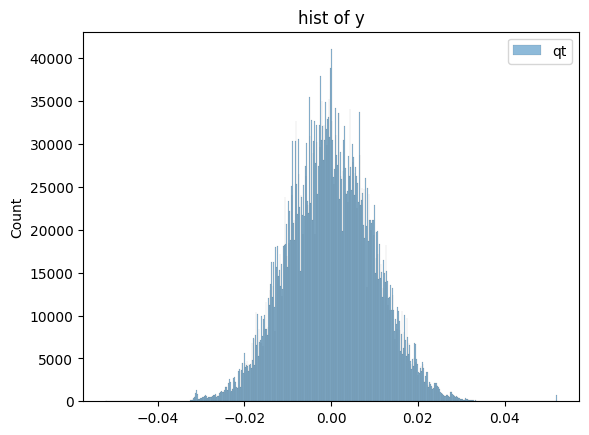

In [22]:
import matplotlib.pyplot as plt
sns.histplot(y_train,label='qt',alpha=0.5)
# sns.histplot(utils.df_train.y_1,label='raw',alpha=0.5)
plt.legend()
plt.title('hist of y')

In [5]:
model.eval()
y_test_pred = model(th.tensor(X_test.values,dtype=th.float32)).detach().numpy().flatten()/RET_SCALER

In [6]:
y_test_pred = qtformer.inverse_transform(y_test_pred.reshape(-1,1)).flatten()


In [7]:
mmt = utils.ModelMetrics(y_test_pred,y_test,utils.test_date)
mmt.evaluate()

Information Coefficient: 0.0728
Average Returns of Top 10%: 0.0019
Accuracy of Top 10%: 0.0994


In [8]:
df_metrics = pd.DataFrame(pd.DataFrame({"y_test":y_test,"y_test_pred":y_test_pred}))

In [9]:
df_metrics.describe()

,y_test,y_test_pred
count,2.813980e+06,2.813980e+06
mean,2.328628e-04,-1.864175e-03
std,2.839369e-02,2.708265e-03
min,-2.743507e-01,-1.974588e-01
25%,-1.420295e-02,-2.617863e-03
50%,-2.060175e-03,-1.338742e-03
75%,1.158118e-02,-4.703488e-04
max,4.614886e-01,1.707769e-02


<AxesSubplot: xlabel='y_test', ylabel='y_test_pred'>

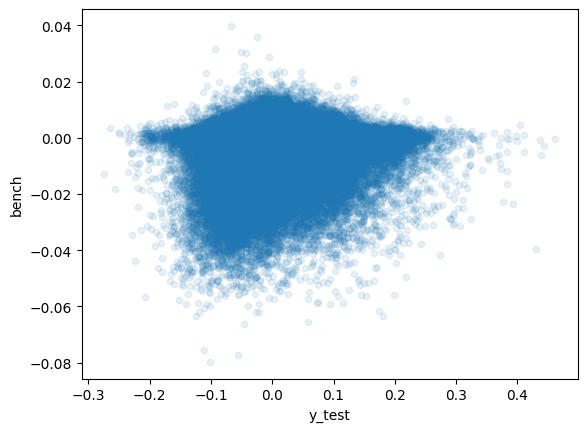

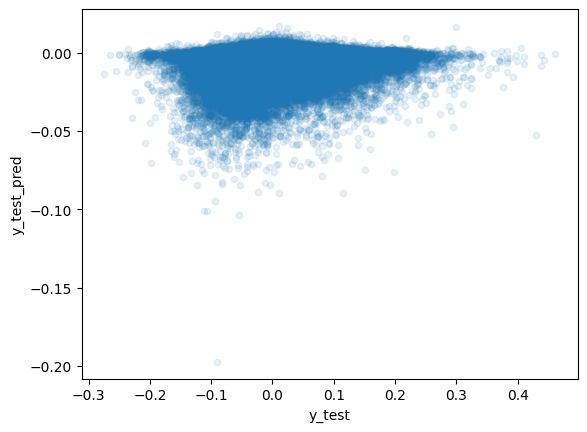

In [10]:
df_metrics['bench'] = utils.df_test.benchmark_yhat
df_metrics.plot(kind='scatter',x = 'y_test',y = 'bench',alpha=0.1)
df_metrics.plot(kind='scatter',x = 'y_test',y = 'y_test_pred',alpha=0.1)


In [11]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


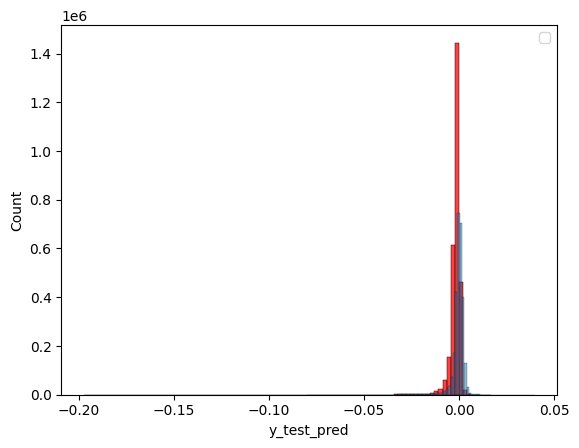

In [12]:

sns.histplot(df_metrics['y_test_pred'],bins=100,color='red')
# sns.histplot(df_metrics['y_test'],bins=100,alpha=0.5)
sns.histplot(df_metrics['bench'],bins=100,alpha=0.5)
plt.legend()

<AxesSubplot: ylabel='y_test_pred'>

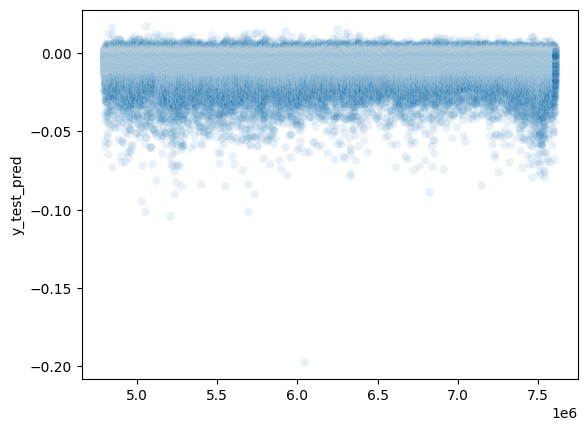

In [13]:
sns.scatterplot(x=df_metrics.index,y=df_metrics['y_test_pred'],alpha=0.1)

<AxesSubplot: ylabel='y_test'>

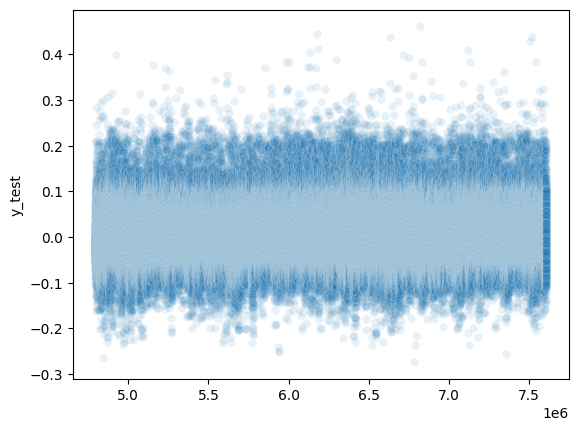

In [14]:
sns.scatterplot(x=df_metrics.index,y=df_metrics['y_test'],alpha=0.1)

<AxesSubplot: ylabel='benchmark_yhat'>

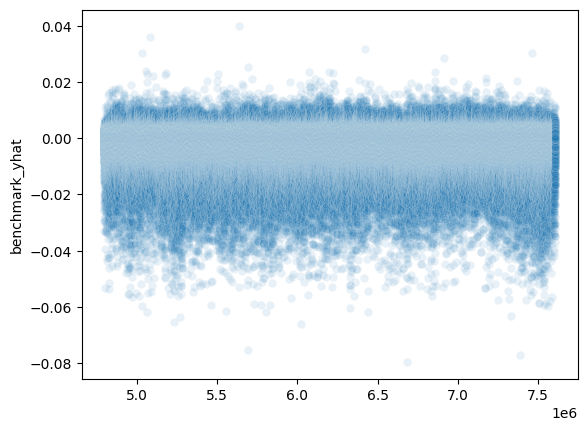

In [15]:
sns.scatterplot(x=df_metrics.index,y=utils.df_test.benchmark_yhat,alpha=0.1)